In [87]:
# Import necessary modules
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [88]:
# Import our input dataset
GeneticDisorder_df = pd.read_csv(
    Path(r"Resources\genetic_disorder.csv")
)
GeneticDisorder_df.head()

,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Status,Respiratory Rate (breaths/min),Heart Rate (rates/min,Follow-up,...,H/O serious maternal illness,H/O radiation exposure (x-ray),H/O substance abuse,Assisted conception IVF/ART,History of anomalies in previous pregnancies,No. of previous abortion,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Genetic Disorder
0,11.0,No,No,Yes,No,5.209058,Alive,Tachypnea,Tachycardia,Low,...,Yes,No,No,No,Yes,0.0,Multiple,6.669552,slightly abnormal,Mitochondrial genetic inheritance disorders
1,4.0,No,Yes,Yes,Yes,4.752272,Alive,Tachypnea,Tachycardia,Low,...,No,No,No,Yes,Yes,1.0,Multiple,6.397702,abnormal,Multifactorial genetic inheritance disorders
2,6.0,Yes,No,Yes,No,4.620420,Alive,Tachypnea,Tachycardia,High,...,Yes,Yes,Not applicable,No,No,3.0,Multiple,3.000000,slightly abnormal,Mitochondrial genetic inheritance disorders
3,10.0,Yes,Yes,Yes,No,4.751452,Deceased,Normal (30-60),Tachycardia,Low,...,No,Yes,No,Yes,Yes,3.0,Singular,9.382407,abnormal,Mitochondrial genetic inheritance disorders
4,6.0,No,Yes,Yes,Yes,4.876896,Deceased,Tachypnea,Normal,Low,...,Yes,No,No,Yes,No,1.0,Singular,7.370477,normal,Single-gene inheritance diseases


In [89]:
# Drop unnecessary columns
columns_to_remove = ['Patient Id', 'Patient First Name', 'Family Name', 'Father\'s name', 'Institute Name', 'Status', 'Location of Institute','Test 1','Test 2','Test 3','Test 4','Test 5','Symptom 1','Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5','Parental consent', 'No. of previous abortion', 'Disorder Subclass']
columns_to_remove_train = [col for col in columns_to_remove if col in GeneticDisorder_df.columns]
GeneticDisorder_cleaned_df = GeneticDisorder_df.drop(columns=columns_to_remove_train)

In [90]:
# Drop rows with missing values
GeneticDisorder_dropped_df = GeneticDisorder_cleaned_df.dropna()

In [91]:
# Identify non-numeric columns
# non_numeric_columns = GeneticDisorder_cleaned_df.select_dtypes(exclude=['float64', 'int64', 'bool']).columns

# Display unique values in non-numeric columns
# for column in non_numeric_columns:
#    print(f"Unique values in {column}: {GeneticDisorder_cleaned_df[column].unique()}")

In [92]:
# Replace NaN values with the median for numerical columns
# numerical_cols = GeneticDisorder_cleaned_df.select_dtypes(include='number').columns
# GeneticDisorder_cleaned_df[numerical_cols] = GeneticDisorder_cleaned_df[numerical_cols].apply(lambda x: x.fillna(x.median()))

# Replace NaN values with the most frequent entry for categorical columns
# categorical_cols = GeneticDisorder_cleaned_df.select_dtypes(exclude='number').columns
# GeneticDisorder_cleaned_df[categorical_cols] = GeneticDisorder_cleaned_df[categorical_cols].apply(lambda x: x.fillna(x.mode().iloc[0]))

In [93]:
# Replace '-' with 'Not applicable' in the entire DataFrame
GeneticDisorder_dropped_df = GeneticDisorder_dropped_df.copy()
GeneticDisorder_dropped_df.replace('-', 'Not applicable', inplace=True)

In [94]:
# Split the data into X (features) and y (target)
y = GeneticDisorder_dropped_df['Genetic Disorder']
X = GeneticDisorder_dropped_df.drop(columns=['Genetic Disorder'])

In [95]:
# Identify categorical columns and perform one-hot encoding
categorical_columns = X.select_dtypes(include=['object']).columns
GeneticDisorder_encoded_df = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

In [96]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(GeneticDisorder_encoded_df, y, random_state=1, stratify=y)

In [97]:
# Apply oversampling to the training data
oversampler = RandomOverSampler(random_state=1)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [98]:
# Scale the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [99]:
# Create a Random Forest classifier with hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

best_rf_model = grid_search.best_estimator_

In [100]:
# Evaluate the model
train_score = best_rf_model.score(X_train_scaled, y_train)
test_score = best_rf_model.score(X_test_scaled, y_test)

print(f"Training Data Score: {train_score}")
print(f"Testing Data Score: {test_score}")

Training Data Score: 0.8024142312579415
Testing Data Score: 0.5050825921219823


In [101]:
# Generate predictions
rf_training_predictions = best_rf_model.predict(X_train_scaled)
rf_testing_predictions = best_rf_model.predict(X_test_scaled)

In [102]:
# Create confusion matrix for training data
rf_training_matrix = confusion_matrix(y_train, rf_training_predictions)
print("Confusion Matrix for Random Forest model (Training):")
print(rf_training_matrix)

Confusion Matrix for Random Forest model (Training):
[[2417    0    3]
 [ 437    0   47]
 [ 446    0 1372]]


In [103]:
# Create confusion matrix for testing data
rf_testing_matrix = confusion_matrix(y_test, rf_testing_predictions)
print("Confusion Matrix for Random Forest model (Testing):")
print(rf_testing_matrix)

Confusion Matrix for Random Forest model (Testing):
[[735   0  71]
 [143   0  19]
 [546   0  60]]


In [104]:
# Create classification report for training data
rf_training_report = classification_report(y_train, rf_training_predictions)
print("Classification Report for Random Forest model (Training):")
print(rf_training_report)

Classification Report for Random Forest model (Training):
                                              precision    recall  f1-score   support

 Mitochondrial genetic inheritance disorders       0.73      1.00      0.85      2420
Multifactorial genetic inheritance disorders       0.00      0.00      0.00       484
            Single-gene inheritance diseases       0.96      0.75      0.85      1818

                                    accuracy                           0.80      4722
                                   macro avg       0.57      0.58      0.56      4722
                                weighted avg       0.75      0.80      0.76      4722



c:\Users\starl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\starl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\starl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [105]:
# Create classification report for testing data
rf_testing_report = classification_report(y_test, rf_testing_predictions)
print("Classification Report for Random Forest model (Testing):")
print(rf_testing_report)

Classification Report for Random Forest model (Testing):
                                              precision    recall  f1-score   support

 Mitochondrial genetic inheritance disorders       0.52      0.91      0.66       806
Multifactorial genetic inheritance disorders       0.00      0.00      0.00       162
            Single-gene inheritance diseases       0.40      0.10      0.16       606

                                    accuracy                           0.51      1574
                                   macro avg       0.31      0.34      0.27      1574
                                weighted avg       0.42      0.51      0.40      1574



c:\Users\starl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\starl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\starl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [106]:
# Print the balanced_accuracy score of the model
print(f"The balanced_accuracy score of the Random Forest model: {balanced_accuracy_score(y_test, rf_testing_predictions)}")


The balanced_accuracy score of the Random Forest model: 0.33697352365509503


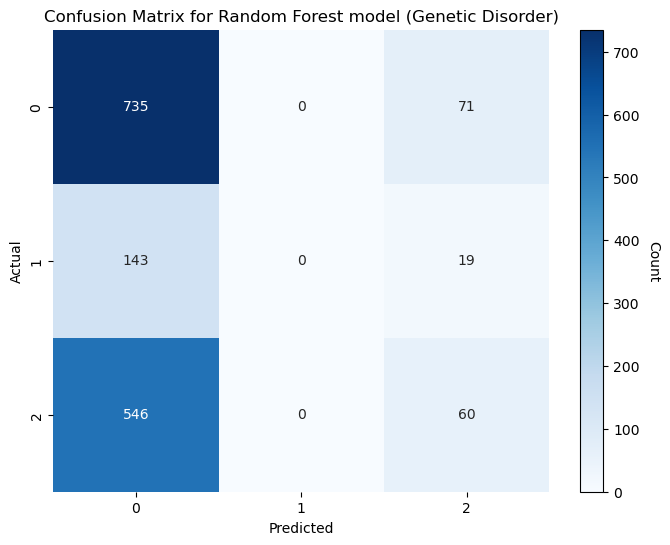

In [107]:
# Confusion Matrix Heatmap for Random Forest model
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(rf_testing_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Random Forest model (Genetic Disorder)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Add legend
cbar = heatmap.figure.colorbar(heatmap.collections[0])
cbar.set_label('Count', rotation=270, labelpad=15)

plt.show()

In [108]:
# Display feature importances
feature_importances = best_rf_model.feature_importances_
all_feature_names = GeneticDisorder_encoded_df.columns

feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importance_df)

Feature Importances:
                                              Feature  Importance
1                              Blood cell count (mcL)    0.163344
2    White Blood cell count (thousand per microliter)    0.144156
0                                         Patient Age    0.101735
17                           Place of birth_Institute    0.024264
24                    Assisted conception IVF/ART_Yes    0.024013
26                             Birth defects_Singular    0.023913
25   History of anomalies in previous pregnancies_Yes    0.023896
3                          Genes in mother's side_Yes    0.023857
9                                       Follow-up_Low    0.023820
18         Folic acid details (peri-conceptional)_Yes    0.022929
23                            H/O substance abuse_Yes    0.022602
19                   H/O serious maternal illness_Yes    0.022530
7            Respiratory Rate (breaths/min)_Tachypnea    0.022507
6                                   Paternal gene_Yes  